# Using _Intake_ as an Alternative to the _COSIMA Cookbook_

**This script shows how to move from the cosima_cookbook to intake** to load and plot sea ice concentration from CICE output.

This is concise version of the longer [COSIMA training workshop](https://github.com/ACCESS-Hive/cosima-training-workshop-2023/blob/main/Intake.ipynb) on the Intake Catalog, and the [documentation](https://access-nri-intake-catalog.readthedocs.io/). At the time of writing (Oct 2023), the ACCESS-NRI Intake Catalog was under testing and feedback from users is requested.

**Notes that are relevant to changing from the cookbook to intake are in BOLD**

Requirements: The conda/analysis3 (tested on analysis3-23.04) module from /g/data/hh5/public/modules. 

**Firstly, load modules, using intake instead of cosima_cookbooks**:

In [1]:
import intake # instead of import cosima_cookbook as cc
import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr
import cartopy.crs as ccrs

And start a dask client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40381,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:41159,Total threads: 3
Dashboard: /proxy/34643/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:45297,


**Open the catalog (similar to the old starting a database session)**

In [3]:
catalog = intake.cat.access_nri
# session = cc.database.create_session()

**You can browse the catalogue (instead of the database explorer, just run `catalog`) or browse the results of a search:**

In [4]:
catalog.search(model='ACCESS-OM2')

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1day, 1mon, fx, 3hr, 3mon}","{temp_submeso, area_u, fprec_melt_heat, flatn_ai_m, TLAT, total_ocean_calving_melt_heat, dyu, v, ty_trans_rho, congel_m, fmelttn_ai_m, alvdf_ai_m, total_ocean_swflx_vis, temp_surface_ave, total_oc..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{area_u, fprec_melt_heat, flatn_ai_m, TLAT, total_ocean_calving_melt_heat, dyu, v, ty_trans_rho, congel_m, fmelttn_ai_m, dvidtt, vorticity_z, snoice_m, alvdf_ai_m, total_ocean_swflx_vis, temp_surf..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{bottom_temp_max, dvirdgdt_m, area_u, fprec_melt_heat, flatn_ai_m, Tinz_m, TLAT, melts_m, dyu, v, ty_trans_rho, congel_m, fmelttn_ai_m, dvidtt, snoice_m, alvdf_ai_m, total_ocean_swflx_vis, meltb_m..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{bottom_temp_max, dvirdgdt_m, area_u, fprec_melt_heat, flatn_ai_m, Tinz_m, TLAT, melts_m, dyu, v, ty_trans_rho, congel_m, fmelttn_ai_m, dvidtt, snoice_m, alvdf_ai_m, total_ocean_swflx_vis, meltb_m..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, 1mon, fx, 6hr, 3hr}","{bottom_temp_max, dvirdgdt_m, area_u, Tinz_m, melts_m, v, radbio_intmld, alvdf_ai_m, det_intmld, meltb_m, ty_trans, kmu, tx_trans_int_z, uvel, dardg2dt_m, time_bounds, salt_surface_ave, surface_po..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 0hr, 1day, fx}","{bottom_temp_max, dvirdgdt_m, area_u, fprec_melt_heat, surface_no3, flatn_ai_m, no3, albsni, TLAT, dic_intmld, dyu, melts_m, v, radbio_intmld, ty_trans_rho, congel_m, fmelttn_ai_m, surface_phy, su..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1mon, 1day, fx}","{area_u, fprec_melt_heat, TLAT, dyu, v, ty_trans_rho, runoff, ty_trans, kmu, tx_trans_int_z, blkmask, sfc_salt_flux_restore, geolat_t, time_bounds, sens_heat, aice, tau_y, sfc_salt_flux_ice, surfa..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{1mon, 1day, 1yr, fx}","{bottom_temp_max, temp_submeso, area_u, fprec_melt_heat, mld_min, horz_bih_diss, dvirdgdt_m, flatn_ai_m, mld_sq, TLAT, melts_m, dyu, v, total_volume_seawater, ty_trans_rho, congel_m, fmelttn_ai_m,..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{1mon, 1day, 1yr, fx}","{bottom_temp_max, temp_submeso, area_u, fprec_melt_heat, mld_min, horz_bih_diss, dvirdgdt_m, flatn_ai_m, mld_sq, TLAT, melts_m, dyu, v, total_volume_seawater, ty_trans_rho, congel_m, fmelttn_ai_m,..."


We are going to load sea ice concentration (`aice_m`) from the Repeat-Year forcing experiment. 

These are the arguments used with 'getvar' from the cosima cookbook

In [5]:
sic_args = {
    "expt": "01deg_jra55v13_ryf9091",
    "variable": "aice_m",
    "start_time": "2090-02-01",
    "end_time":"2100-01-01",
    "decode_coords":False
}

**Instead of 'getvar' we use search, and specify the experiment name and the variable**

In [6]:
var=catalog[sic_args['expt']].search(variable=sic_args['variable'])

# var = cc.querying.getvar(
#     session=session, 
#     **sic_args
# )


**At this point we don't have an xarray object yet, we just have a dataframe of entries in the catalog. We need to call 'to_dask()' to create the xarray dataset, which will attempt to merge and concatenate all the files relating to entries in the catalog.**
- For CICE data, its simpler to use `decode_coords:False` in both the cookbook and intake.
- To speed up the xarray combining of data files, we pass some extra `xarray_combine_by_coords_kwargs` arguments. This is safe because we are only using curated results from one model run. Be careful using these arguments if opening results from more than one model or dataset.

In [7]:
%%time
sic=var.to_dask(
    xarray_open_kwargs={
        "decode_coords":False
    },
    xarray_combine_by_coords_kwargs={
    'compat':'override','data_vars':'minimal', 'coords':'minimal'
    }
)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 10.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 30.6 s, sys: 2.52 s, total: 33.1 s
Wall time: 1min 42s


**Intake has returned a dataset, when cosima cookbook would return a datarray, so select the dataarray for our variable:**

In [8]:
sic=sic.aice_m

Per [other notebooks](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/IcePlottingExample.html), CICE thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.  
  
To get around this and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [9]:
sic['time'] = sic.time.to_pandas() - timedelta(hours = 12)

**Intake doesn't include filtering by time ranges in the 'search' command. As we have only lazy loaded the data so far, this is a good time to to subset to only use the years we are interested in (similar to start_time and end_time arguments in 'getvar')**

In [10]:
sic=sic.sel(time=slice('2090','2099'))

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does. So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

**There are many output files with the area field, and we only want one, so lets include the start date to force the catalog to only return one file to open. (We used _n=1_ in the cookbook, there is an [open issue](https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/117) to try and improve this.)**

In [11]:
# area_t = cc.querying.getvar(sic_args['expt'], 'area_t',session,n = 1)
area_t=catalog[sic_args['expt']].search(variable='area_t', start_date='2090-01-01,*').to_dask().load()

In [12]:
area_t

<xarray.Dataset>
Dimensions:   (yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
Data variables:
    area_t    (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    filename:                                 ocean_grid.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['area_t']
    intake_esm_attrs:path:                    /g/data/ik11/outputs/access-om2...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  sea_floor_depth_below_geoid
    intake_esm_attrs:variable_cell_methods:   time: point,time: point,time: p...
    intake_esm_attrs:filename:                ocean_grid.nc
    intake_esm_attrs:file_id:                 ocean_grid
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_grid.fx

**There are no more changes to the notebook to use intake, we can plot the data, for example**

Our CICE data is missing x&y coordinate values, so we can also get them from area_t

In [13]:
sic.coords['ni'] = area_t['xt_ocean'].values
sic.coords['nj'] = area_t['yt_ocean'].values

So that our new coordinates are recognised as cf standard, we also need to copy the attributes. This notebook is designed to use `cf-xarray`. This means the rest of the notebook is [Model Agnostic](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html).

In [14]:
sic.ni.attrs=area_t.xt_ocean.attrs
sic.nj.attrs=area_t.yt_ocean.attrs

In [15]:
sic = sic.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

We need the geolon and geolat fields from area_t

In [16]:
sic=sic.assign_coords({
    'geolat_t':area_t.geolat_t,
    'geolon_t':area_t.geolon_t
})

Using cartopy, we can make Polar Stereographic plots of sea ice concentration for a selected month, as follows:

In [17]:
def plot_si_conc(data):
    """ A function for plotting tri-polar data"""
    
    data.plot.contourf(
        transform=ccrs.PlateCarree(),
        x='geolon_t', 
        y='geolat_t', 
        levels=33 ,
        cbar_kwargs={
            'label':'Sea Ice Concentration'
        }
    )

    ax=plt.gca()
    gl = ax.gridlines(
            draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--',
            # xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], 
            #ylocs=[-50,-60,-70,-80]
        )

    ax.coastlines()


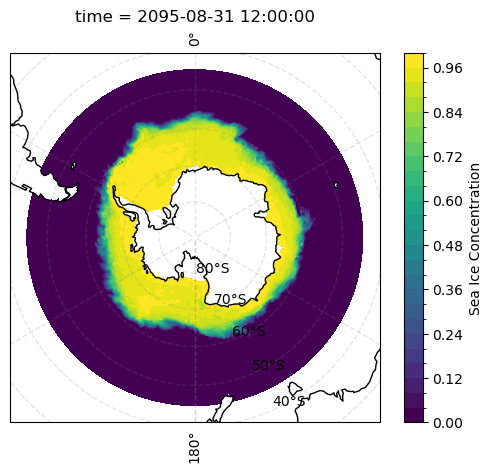

In [18]:
def plot_sh_si_conc():
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())
    plot_si_conc(
        sic.cf.sel(latitude=slice(-90,-45), time='2095-08')[0]
    )

plot_sh_si_conc()

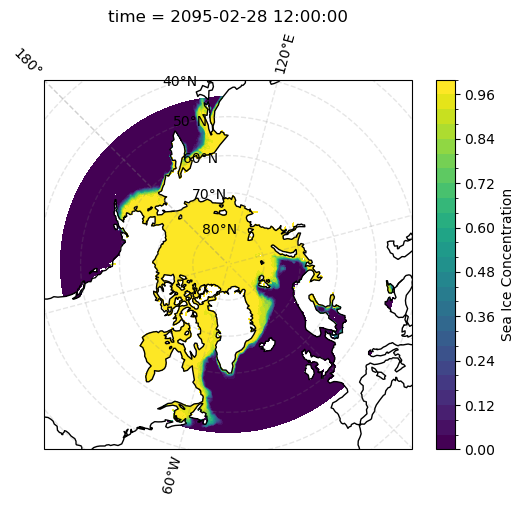

In [19]:
def plot_nh_si_conc():
    crs=ccrs.NorthPolarStereo(central_longitude=-45,true_scale_latitude=70)
    ax=plt.subplot(projection=crs)
    plot_si_conc(
        sic.cf.sel(latitude=slice(45,90), time='2095-02')[0]
    )

plot_nh_si_conc()